In [1]:
import pandas as pd

# Load all cities information 

In [3]:
cities_df = pd.read_csv('./../data/simplemaps_worldcities_basicv1.4/worldcities.csv')

In [5]:
cities_df.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Malishevë,Malisheve,42.4822,20.7458,Kosovo,XK,XKS,Malishevë,admin,NaN,1901597212
1,Prizren,Prizren,42.2139,20.7397,Kosovo,XK,XKS,Prizren,admin,NaN,1901360309
2,Zubin Potok,Zubin Potok,42.9144,20.6897,Kosovo,XK,XKS,Zubin Potok,admin,NaN,1901608808
3,Kamenicë,Kamenice,42.5781,21.5803,Kosovo,XK,XKS,Kamenicë,admin,NaN,1901851592
4,Viti,Viti,42.3214,21.3583,Kosovo,XK,XKS,Viti,admin,NaN,1901328795


### Filter out cities, which are located in Ukraine and remove unused columns

In [14]:
ua_cities_df = cities_df[cities_df['country']=='Ukraine'][['city', 'lat', 'lng']]

In [15]:
print(ua_cities_df.shape)
ua_cities_df.head()

(51, 3)


,city,lat,lng
3532,Uzhgorod,48.6300,22.2500
3533,Kiev,50.4334,30.5166
3534,Ivano-Frankivsk,48.9348,24.7094
3535,Kherson,46.6325,32.6007
3536,Donetsk,48.0000,37.8300


### There is 51 posible cities, lets render it to the map

In [27]:
def show_map(location_df, zoom_start=6.3):
    """
    Function for create map
    """
    latitude = location_df['lat'].mean()
    longitude = location_df['lng'].mean()
    map_render = folium.Map(location=[latitude, longitude], zoom_start=zoom_start)

    # add markers to map
    for lat, lng, name in zip(location_df['lat'], location_df['lng'], location_df['city']):
        label = folium.Popup(name, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=16,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_render)  

    return map_render

In [28]:
show_map(ua_cities_df)

# Fetch additional information about each city

In [31]:
CLIENT_ID = '*****'
CLIENT_SECRET = '*****'
VERSION = '20180605' # Foursquare API version
LIMIT = 1000
radius = 500

In [32]:
import requests 

In [53]:
def getNearbyVenues(names, latitudes, longitudes, radius=10000):
    limit = 50
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        for i in range(int(LIMIT / limit)):
            # create the API request URL
            url = (
                f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}'
                f'&client_secret={CLIENT_SECRET}&v={VERSION}&ll={lat},{lng}&radius={radius}&limit={limit}&offset={limit * i}'
            )
            # make the GET request
            results = requests.get(url).json()["response"]
            if 'groups' not in results:
                break
            
            results = results['groups'][0]['items']        
            # return only relevant information for each nearby venue
            venues_list.append(
                [
                    (name, lat, lng, v['venue']['name'], v['venue']['categories'][0]['id']) 
                    for v in results
                ]
            )

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 'lat', 'lng', 'venue_name', 'category_id']
    
    return nearby_venues

### If the file was fetched previously load it from file system otherwise - fetch from foursquare

In [58]:
ua_cities_df = cities_df[cities_df['country']=='Ukraine'][['city', 'lat', 'lng']]
cities_venus_cat_df = cities_venus_cat_df.to_csv('./../data/cities_venus_cat_df.csv')
if cities_venus_cat_df is None:
    cities_venus_cat_df = getNearbyVenues(ua_cities_df['city'], ua_cities_df['lat'], ua_cities_df['lng'])
    cities_venus_cat_df.to_csv('./../data/cities_venus_cat_df.csv')

In [62]:
cities_venus_cat_df.head()

,City,lat,lng,venue_name,category_id
0,Uzhgorod,48.63,22.25,Maximus Gym,4bf58dd8d48988d176941735
1,Uzhgorod,48.63,22.25,Лаборця 2,4bf58dd8d48988d16d941735
2,Uzhgorod,48.63,22.25,MUFFIN CAFE,4bf58dd8d48988d1e0931735
3,Uzhgorod,48.63,22.25,Goriziana Caffe / Горіціана Кафе,4bf58dd8d48988d1e0931735
4,Uzhgorod,48.63,22.25,Viper Gym,4bf58dd8d48988d175941735


In [63]:
cities_venus_cat_df['category_id'].nunique()

303

### There are 303 different venue types in our dataset. It is too large a differentiation for our task. Let`s reduce variation of the category_id

[function doc](https://developer.foursquare.com/docs/api/venues/categories)

In [72]:
url = f'https://api.foursquare.com/v2/venues/categories?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}'
cat_tree = requests.get(url).json()["response"]['categories']

In [71]:
def reduce_categories(cat_list, subcategories, parent_categories = None):
    for cat in subcategories:
        if parent_categories:
            cat_list.append((cat['id'], parent_categories))
        if cat['categories']:
            reduce_categories(cat_list, cat['categories'], parent_categories or cat['id'])
        

In [77]:
cat_map = []
reduce_categories(cat_map,cat_tree)
cat_map_df = pd.DataFrame(cat_map)
cat_map_df.columns = ['sub_cat', 'general_cat']

In [81]:
print('shape of the cat_map_df:')
print(cat_map_df.shape)
print('count of the general categories')
print(cat_map_df['general_cat'].nunique())
cat_map_df.head()

shape of the cat_map_df:
(927, 2)
count of the general categories
10


,sub_cat,general_cat
0,56aa371be4b08b9a8d5734db,4d4b7104d754a06370d81259
1,4fceea171983d5d06c3e9823,4d4b7104d754a06370d81259
2,4bf58dd8d48988d1e1931735,4d4b7104d754a06370d81259
3,4bf58dd8d48988d1e2931735,4d4b7104d754a06370d81259
4,4bf58dd8d48988d1e4931735,4d4b7104d754a06370d81259


In [84]:
cities_venus_cat_df = cities_venus_cat_df.join(cat_map_df.set_index('sub_cat'), on='category_id')

### Lets look to the result of the reduce of the categories variation

In [87]:
cities_venus_cat_df['general_cat'].nunique()

8

In [88]:
cities_venus_cat_df.head()

,City,lat,lng,venue_name,category_id,general_cat
0,Uzhgorod,48.63,22.25,Maximus Gym,4bf58dd8d48988d176941735,4d4b7105d754a06377d81259
1,Uzhgorod,48.63,22.25,Лаборця 2,4bf58dd8d48988d16d941735,4d4b7105d754a06374d81259
2,Uzhgorod,48.63,22.25,MUFFIN CAFE,4bf58dd8d48988d1e0931735,4d4b7105d754a06374d81259
3,Uzhgorod,48.63,22.25,Goriziana Caffe / Горіціана Кафе,4bf58dd8d48988d1e0931735,4d4b7105d754a06374d81259
4,Uzhgorod,48.63,22.25,Viper Gym,4bf58dd8d48988d175941735,4d4b7105d754a06377d81259


In [90]:
cities_by_with_dumies = pd.get_dummies(cities_venus_cat_df[['general_cat']], prefix="", prefix_sep="")
cities_by_with_dumies['City'] = cities_venus_cat_df['City']

## Let's examine cities with dummy encoded venue types. 

In [92]:
cities_by_with_dumies.head()

,4d4b7104d754a06370d81259,4d4b7105d754a06372d81259,4d4b7105d754a06374d81259,4d4b7105d754a06375d81259,4d4b7105d754a06376d81259,4d4b7105d754a06377d81259,4d4b7105d754a06378d81259,4d4b7105d754a06379d81259,City
0,0,0,0,0,0,1,0,0,Uzhgorod
1,0,0,1,0,0,0,0,0,Uzhgorod
2,0,0,1,0,0,0,0,0,Uzhgorod
3,0,0,1,0,0,0,0,0,Uzhgorod
4,0,0,0,0,0,1,0,0,Uzhgorod


In [94]:
cities_by_with_dumies = cities_by_with_dumies.groupby('City').sum()

In [95]:
cities_by_with_dumies.head()

,4d4b7104d754a06370d81259,4d4b7105d754a06372d81259,4d4b7105d754a06374d81259,4d4b7105d754a06375d81259,4d4b7105d754a06376d81259,4d4b7105d754a06377d81259,4d4b7105d754a06378d81259,4d4b7105d754a06379d81259
City,,,,,,,,
Berdyansk,6,0,13,0,3,26,3,7
Bila Tserkva,3,0,29,0,1,19,15,5
Brovary,3,0,31,0,1,25,26,5
Cherkasy,8,0,34,2,1,22,18,4
Chernihiv,14,0,27,3,3,19,11,4


### Apply normalization and add one more column with total count of the venue 

In [150]:
sum_of_item_by_city = cities_by_with_dumies.sum(axis=1) 
cities_by_with_dumies_norm = cities_by_with_dumies.copy()
for col in cities_by_with_dumies.columns:
    cities_by_with_dumies_norm[col] = cities_by_with_dumies[col]/sum_of_item_by_city
cities_by_with_dumies_norm['total'] = (sum_of_item_by_city/sum_of_item_by_city.sum())

In [151]:
cities_by_with_dumies_norm.head()

,4d4b7104d754a06370d81259,4d4b7105d754a06372d81259,4d4b7105d754a06374d81259,4d4b7105d754a06375d81259,4d4b7105d754a06376d81259,4d4b7105d754a06377d81259,4d4b7105d754a06378d81259,4d4b7105d754a06379d81259,total
City,,,,,,,,,
Berdyansk,0.103448,0.0,0.224138,0.000000,0.051724,0.448276,0.051724,0.120690,0.016609
Bila Tserkva,0.041667,0.0,0.402778,0.000000,0.013889,0.263889,0.208333,0.069444,0.020619
Brovary,0.032967,0.0,0.340659,0.000000,0.010989,0.274725,0.285714,0.054945,0.026060
Cherkasy,0.089888,0.0,0.382022,0.022472,0.011236,0.247191,0.202247,0.044944,0.025487
Chernihiv,0.172840,0.0,0.333333,0.037037,0.037037,0.234568,0.135802,0.049383,0.023196


### Let`s create clustes

In [152]:
from sklearn.cluster import KMeans

In [186]:
cities_clustering = cities_by_with_dumies_norm.reset_index().drop('City', 1)

clustering_result = pd.DataFrame()
inertia = []
cluster_count = []
for i in range(3,int(len(cities_clustering)-1)):
    print(f"\n Clustering by {i}")
    kmeans = KMeans(n_clusters=i).fit(cities_clustering)
    print(kmeans.inertia_)
    print(f'inertia :: {kmeans.inertia_}')
    inertia.append(kmeans.inertia_)
    cluster_count.append(i)


 Clustering by 3
0.7952371692773813
inertia :: 0.7952371692773813

 Clustering by 4
0.5971154028580731
inertia :: 0.5971154028580731

 Clustering by 5
0.4989110072054772
inertia :: 0.4989110072054772

 Clustering by 6
0.43896587387114294
inertia :: 0.43896587387114294

 Clustering by 7
0.39425418076553476
inertia :: 0.39425418076553476

 Clustering by 8
0.34538111777776215
inertia :: 0.34538111777776215

 Clustering by 9
0.317341837238007
inertia :: 0.317341837238007

 Clustering by 10
0.27955851542763954
inertia :: 0.27955851542763954

 Clustering by 11
0.25001188972337857
inertia :: 0.25001188972337857

 Clustering by 12
0.22298426000784352
inertia :: 0.22298426000784352

 Clustering by 13
0.20958183135039538
inertia :: 0.20958183135039538

 Clustering by 14
0.18923912602680212
inertia :: 0.18923912602680212

 Clustering by 15
0.1683154865506679
inertia :: 0.1683154865506679

 Clustering by 16
0.15189569760336108
inertia :: 0.15189569760336108

 Clustering by 17
0.141236211093261
in

In [187]:
import matplotlib
import matplotlib.pyplot as plt

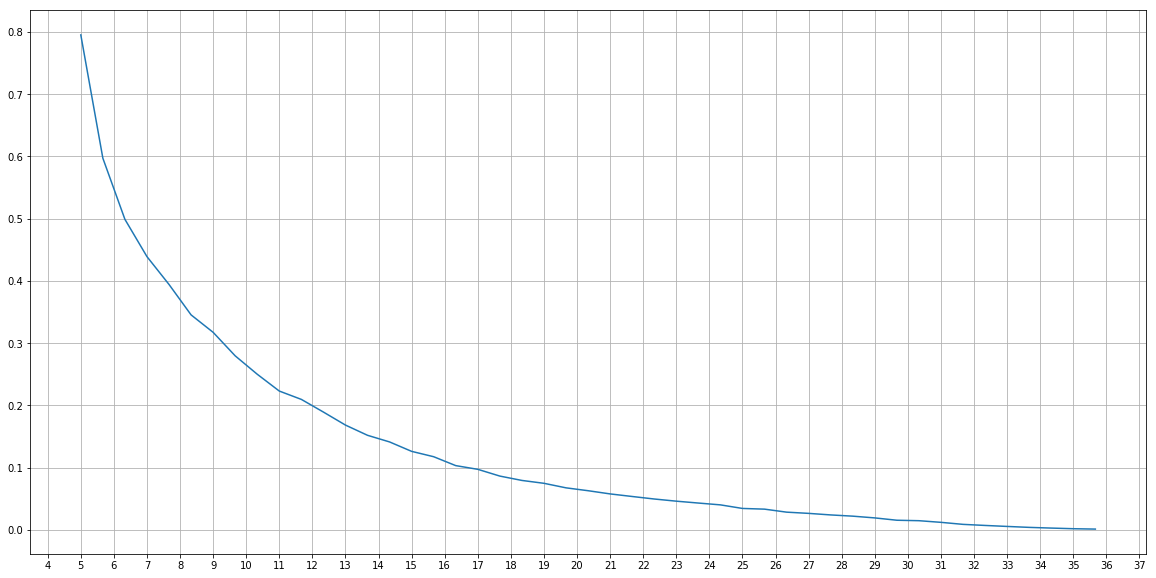

In [215]:
# a = plt.
# plt.xaxis.set_major_locator(plt.MaxNLocator(3))
# plt.show()


fig, ax = plt.subplots(figsize=(20,10))


def format_fn(tick_val, tick_pos):
    return str(tick_val)

ax.plot(cluster_count, inertia)
ax.xaxis.set_major_locator(plt.MaxNLocator(len(cluster_count)))
ax.set_xticklabels(cluster_count)
ax.figsize=(30,40)
ax.grid()


# Lets fix 32 as optimal cluster count, because after this value inertia stop to decrease dramatically

In [246]:
kclusters = 32
kmeans = KMeans(n_clusters=kclusters).fit(cities_clustering)

In [247]:
ua_cities_with_type_df = ua_cities_df
ua_cities_with_type_df['types'] = kmeans.labels_

In [248]:
ua_cities_with_type_df.head()

,city,lat,lng,types
3532,Uzhgorod,48.6300,22.2500,4
3533,Kiev,50.4334,30.5166,19
3534,Ivano-Frankivsk,48.9348,24.7094,5
3535,Kherson,46.6325,32.6007,19
3536,Donetsk,48.0000,37.8300,28


In [249]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

In [250]:
latitude = ua_cities_with_type_df['lat'].mean()
longitude = ua_cities_with_type_df['lng'].mean()

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(ua_cities_with_type_df['lat'], ua_cities_with_type_df['lng'], ua_cities_with_type_df['city'], ua_cities_with_type_df['types']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=16,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

# Conclusion:
For our purpose, we will propose customers to choose some city, that place in the other cluster. As a result, he or she received a recommendation to visit something, that different from the usual environment. 